# Yelp Reviews on Boston Restaurants

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import stylecloud
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer

import re
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

import warnings; warnings.simplefilter('ignore')

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

sns.set(context = 'paper', style='white', font_scale = 0.8)


### Data Overview

In [2]:
business = pd.read_csv('boston_restaurants.csv', index_col=0)

In [3]:
business.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,hcRxdDg7DYryCxCoI8ySQA,Longwood Galleria,340-350 Longwood Ave,Boston,MA,2215,42.338544,-71.106842,2.5,24,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Restaurants, Shopping, Shopping Centers","{'Monday': '6:30-22:0', 'Tuesday': '6:30-22:0'..."
1,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,1 Harborside Dr,Boston,MA,2128,42.363442,-71.025781,3.5,856,1,"{'NoiseLevel': ""u'average'"", 'BikeParking': 'F...","Sandwiches, Food, Restaurants, Breakfast & Bru...","{'Monday': '6:0-21:0', 'Tuesday': '6:0-21:0', ..."
2,iPD8BBvea6YldQZPHzVrSQ,Espresso Minute,334 Mass Ave,Boston,MA,2115,42.342673,-71.084239,4.5,7,0,"{'NoiseLevel': ""'quiet'"", 'GoodForKids': 'True...","Creperies, Restaurants, Food, Coffee & Tea, Br...","{'Tuesday': '8:0-20:0', 'Wednesday': '8:0-20:0..."


In [4]:
#checking for duplicates
business.shape

(2846, 14)

In [5]:
#checking for duplicates
business.drop_duplicates('business_id', inplace=True)

In [6]:
#Grouping rating stars to get total review counts for each rating
star_grouped = business.groupby(['stars']).agg(np.sum).reset_index()

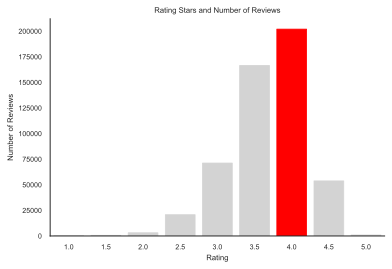

In [7]:
ax=sns.barplot(x=star_grouped['stars'], y=star_grouped['review_count'],ci=None)
for bar in ax.patches:
    if bar.get_height() > 175000:
        bar.set_color('red')    
    else:
        bar.set_color('lightgrey')
ax.set_title('Rating Stars and Number of Reviews')
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Reviews')
sns.despine();

The most common rating for restuarants in Boston is 4 stars and the least number of reviews is 1 star.

In [8]:
reviews = pd.read_csv('reviews.csv', index_col=0)

In [9]:
#Drop columns that we will not be using
reviews.drop(['address','city','state','postal_code',
              'latitude','longitude','stars_x','review_count',
             'is_open','attributes','categories','hours','name',
              'user_id','useful','funny','cool','date'], axis=1, inplace=True)

reviews.rename(columns={'stars_y':'review_star'},inplace=True)

In [10]:
reviews.shape

(532632, 4)

In [11]:
reviews.head(3)

,business_id,review_id,review_star,text
0,hcRxdDg7DYryCxCoI8ySQA,CN3Ne8rJitD5nsERjxQq1A,3,The Longwood Galleria isn't much of a mall. It...
1,hcRxdDg7DYryCxCoI8ySQA,GAvDmiTC0lkYSF1RYzc2rQ,3,The food court can get a bit crowded during lu...
2,hcRxdDg7DYryCxCoI8ySQA,UPrSxZGLDT0L8zwJpw9_NQ,5,"I'll give 5 stars to this cozy, cute and shiny..."


In [12]:
reviews['review_star'].value_counts(normalize=True)

5    0.353465
4    0.290461
3    0.152340
1    0.104808
2    0.098926
Name: review_star, dtype: float64

About **64%** of all reviews are composed of 4 and 5 stars.

In [13]:
#Finding the length (by character and by word) of each review
reviews['character_count'] = reviews['text'].map(len)
reviews['word_count'] = reviews['text'].apply(lambda x: len(str(x).split(" ")))

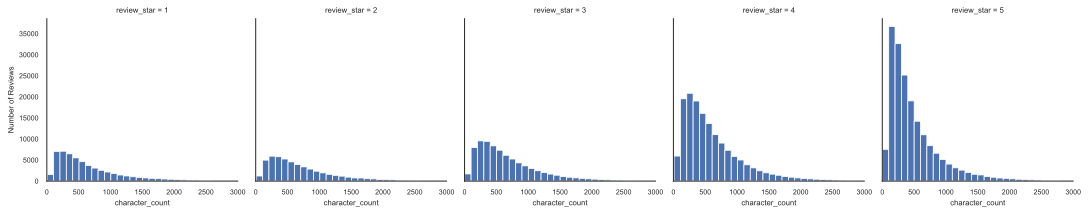

In [14]:
ax = sns.FacetGrid(data=reviews, col='review_star', xlim=(0, 3000)).map(plt.hist, 'character_count', bins=50)
ax.axes[0][0].set(ylabel='Number of Reviews');

All ratings are right-skewed. Restaurants with a rating star of 1, 2, and 3 have fairly similar distribution, however rating stars 4 and 5 have a more right skewed distribution due to having more reviews. Lets find the average review length for each star.

In [15]:
review_length_grouped = reviews.groupby('review_star')['character_count'].agg(np.mean)
print('Average Review Length for all Restaurants: {}'.format(round(reviews['character_count'].mean())))
print('Average Review Length for 1 Star Restaurants: {}'.format(round(review_length_grouped.iloc[0])))
print('Average Review Length for 2 Star Restaurants: {}'.format(round(review_length_grouped.iloc[1])))
print('Average Review Length for 3 Star Restaurants: {}'.format(round(review_length_grouped.iloc[2])))
print('Average Review Length for 4 Star Restaurants: {}'.format(round(review_length_grouped.iloc[3])))
print('Average Review Length for 5 Star Restaurants: {}'.format(round(review_length_grouped.iloc[4])))


Average Review Length for all Restaurants: 622
Average Review Length for 1 Star Restaurants: 711
Average Review Length for 2 Star Restaurants: 749
Average Review Length for 3 Star Restaurants: 708
Average Review Length for 4 Star Restaurants: 632
Average Review Length for 5 Star Restaurants: 515


It looks like the lower the rating the more lengthy the review is, and the higher the rating the shorter the review. The average review length for 5 star restaurants are lower than the average review length of all restaurants. Perhaps, users who are not satisified with a restaurant are more likely to write more in their reviews.

### Data Preprocessing

#### Assigning Sentiment

In [16]:
def sentiment(stars_value):
    if stars_value >= 4.0:
        sentiment = 'positive'
    elif stars_value == 3.0:
        sentiment = 'neutral'
    else:
        sentiment = 'negative'
    return sentiment

In [17]:
reviews['sentiment'] = reviews['review_star'].apply(sentiment)

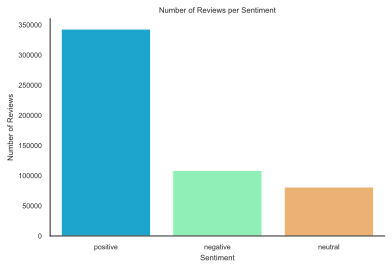

In [18]:
ax = sns.barplot(x=reviews['sentiment'].value_counts().index, y=reviews['sentiment'].value_counts(), palette = 'rainbow')
ax.set_title('Number of Reviews per Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Reviews')
sns.despine();

In [19]:
positive = reviews[reviews['sentiment']=='positive'].reset_index()
negative = reviews[reviews['sentiment']=='negative'].reset_index()
neutral = reviews[reviews['sentiment']=='neutral'].reset_index()

In [20]:
print(positive.shape)
print(negative.shape)
print(neutral.shape)

(342976, 8)
(108515, 8)
(81141, 8)


In [21]:
#Sampling positive and negative reviews only
pos_sample = positive.sample(30000, random_state=42)
neg_sample = negative.sample(30000, random_state=42)


In [22]:
sample_review = pd.concat([pos_sample,neg_sample], axis=0, ignore_index=True)

In [23]:
sample_review.drop('index',axis=1, inplace=True)

In [24]:
sample_review.head()

,business_id,review_id,review_star,text,character_count,word_count,sentiment
0,Hc9l2eLAGTB4lZJI3vRoPw,Lr1km0fiXuyW9pBn1-4u-Q,4,Great service. We went in around 2 PM on a wee...,756,149,positive
1,_RWkck7niE8VJG3zLXK2ig,nJALqXh3fGJAfNobbQ6F_w,4,Came here with a friend on a Saturday night ar...,1075,197,positive
2,CHcwpvcUr1G7bAF0k0JnMQ,8mTx-7ullerN9jwV_8cupg,4,Went there last night with my husband. The ser...,1192,215,positive
3,sRNcBkZrs2bOrijfElHVyQ,fBHHWWEimIF6Hx-NDDp09g,4,This place is SUCH a cute little gem of a hole...,1290,240,positive
4,_HWXgn_S6nSuCfo-VzM7RQ,dJ_ZDGO1u6WjLFg-Z8eZjA,5,Will miss this place sincerely. It was the bes...,131,22,positive


In [25]:
#removing numbers, puncutation, whitespace, and newlines and spell check
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_ws = lambda x: x.rstrip()
remove_n = lambda x: x.replace('\n','')
sample_review['text']= sample_review['text'].map(alphanumeric).map(punc_lower).map(remove_ws).map(remove_n)

#### Baseline Modeling

In [26]:
# topic modeling pipeline

def generate_topics(docs, vectorizer, topic_modeler, print_n_words=15):
    
    # vectorize documents into a document-word matrix
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # fit the topic model
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # generate H matrix that will be fed into the supervised learning model
    H_matrix = pd.DataFrame(doc_topic_vectors.round(5), index=docs)
    
    # print the topics
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i] for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return H_matrix.head()

In [27]:
%%time
#Adding stop words for better topic results
docs = sample_review['text']
vectorizer_1 = TfidfVectorizer(stop_words='english')
topic_modeler_1 = NMF(5, random_state=42) 

generate_topics(docs, vectorizer_1, topic_modeler_1)

Topic 0:
 good, chicken, like, really, just, sauce, ordered, got, salad, place, sandwich, cheese, rice, ve, pretty 

Topic 1:
 minutes, table, food, order, service, time, came, asked, said, told, just, wait, restaurant, didn, bar 

Topic 2:
 lobster, roll, chowder, clam, oysters, rolls, seafood, boston, fresh, best, crab, butter, delicious, oyster, bisque 

Topic 3:
 pizza, crust, cheese, slice, delivery, best, pizzas, slices, toppings, place, order, boston, dough, north, pepperoni 

Topic 4:
 great, food, place, service, amazing, good, atmosphere, friendly, boston, staff, delicious, love, recommend, definitely, best 

CPU times: user 17.6 s, sys: 563 ms, total: 18.1 s
Wall time: 12.5 s


,0,1,2,3,4
text,,,,,
great service we went in around pm on a weekday and it was not that busy so our server was pretty attentive to us i got the bbq onion burger which i thought was great their plates come out with the burger cutely wrapped in a tasty burger wrapper and their fries flipped down inside of a box the presentation is always a plus for me and i thought it was fun to slide the fries out to eat them love that their burgers are cooked at medium and it is very tasty my husband had the gorgonzola burger and seemed to like it enough but it wasn t his favorite blue cheese burger to date the fries are thin but tasty love the tasty burger seasoning to put on top of it they also have spicy ketchup which was yummy a great place for a burger for sure,0.03289,0.00000,0.00000,0.0000,0.01768
came here with a friend on a saturday night around pm silvertone is pretty dark loud so i wouldn t suggest going there if this is not the vibe you re looking for we were seated right away in a corner table our server took a few moments to greet us but immediately took our drink and appetizer order started off with the goat cheese crostini and tomato balsamic bruschetta which was a great combination both appetizer portions were decent in size and very flavorful for entrees i got the veggie burger and my friend got the grilled salmon cajun style my veggie burger was fresh and delicious the sweet potato fries were crisp and served with a spicy aioli on the side the salmon was a good portion and cook perfectly this place is great for some upscale pub food the service was a bit slow i had to ask the waitress about four times for a glass of water and i felt like the beers were actually served a bit warm or possibly just served in a glass right out of dish so it felt warm otherwise i would defiantly return and recommend it to others,0.03308,0.03087,0.00164,0.0000,0.01005
went there last night with my husband the server was extremely attentive and friendly initially i wanted to eat hotpot but i couldn t resist sushi when i was sitting in front of a sushi bar we found out there was an all you can eat deal for the sushi yes my husband who is also japanese said that their sushi is fairly fresh their raw scallop and white tuna are super delicious the fatty salmon was good too i also like their salmon roes and tobiko after eating some cold sushi without eating real lunch i had like an orange and that was it i really wanted some hot soup for my empty stomach i was checking their menu too bad they did not have miso soup but guess what the server offered me a small bowl of warm broth with scallions my stomach felt so much better the only reason i did not give star is the appetizers they were okay perhaps we did not order the best one we had sauteed clams and sauteed beef tongues we will definitely go back to try the hotpot and for the atmosphere this restaurant made us feel welcome and comfortable ever since my husband and i moved from california this is one of the closest customer service we have gotten so far,0.03312,0.01905,0.00595,0.0000,0.00449
this place is such a cute little gem of a hole in the wall recommended by a boston native at my hotel it s diner like vibe was the perfect setting for a late breakfast on an easy tues morning and i love going out to eat breakfast foods the menu is pretty basic with your omelets pancakes waffles and sides of potatoes and breakfast meats galore you first order pay then pick up your food when it s ready so it s not a service oriented place i kinda liked that this place wasn t one of those how are you doing is there anything else i can get you type of all up in your face joint when it s the morning you kinda wanna wake up on your own you know what i mean i think it d be a great place to enjoy some alone time alone reading the morning paper or a brunch date with a few friends it s totally got that homey feel the prices are sort of on the upper end for the amount of food you get but the ingredients are fresh and there 

Our baseline model looks pretty good! We have topics that are distinctive and interpretable. We have topics such as seafood and pizza. There are word like 've', and 'didn' that showed up. Let's keep modeling to get rid of redundant terms.

#### Fine tuning Topic Modeling

In [28]:
#Setting up a class for lemmatization and tokenization

stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

class Token_lemma(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def _lemma(self, token):
        if (token in stop_words):
            return token  
        return self.wnl.lemmatize(token)
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        pos_tags = nltk.pos_tag(tokens)
        tokens_adj_noun = (token[0] for token in pos_tags if token[1] in ['JJ','JJR','JJS','NN','NNP','NNPS','NNS'])  # Selecting only adjectives and nouns
        tokens_lemma = (self._lemma(token) for token in tokens_adj_noun) 
        return list(tokens_lemma)

In [29]:
%%time
# increase number of topics, adding max_features, min_df, tokenizing and lemmatizing
docs =sample_review['text']
vectorizer_2 = TfidfVectorizer(min_df=10,
                               tokenizer=Token_lemma(),
                               token_pattern='[a-z][a-z]+',
                               stop_words=tokenized_stop_words,
                               max_features = 1000
                              )
topic_modeler_2 = NMF(n_components=10,random_state=42)

generate_topics(docs, vectorizer_2, topic_modeler_2)

Topic 0:
 time, order, minute, table, service, customer, hour, waitress, manager, people, rude, server, experience, waiter, reservation 

Topic 1:
 lobster, roll, chowder, clam, oyster, seafood, fresh, boston, crab, sushi, best, good, fish, butter, delicious 

Topic 2:
 pizza, slice, crust, cheese, place, best, delivery, topping, good, boston, thin, pie, sauce, north, new 

Topic 3:
 great, service, staff, friendly, delicious, atmosphere, time, spot, awesome, excellent, location, selection, fantastic, brunch, fun 

Topic 4:
 bar, drink, bartender, beer, night, place, friend, cocktail, nice, people, game, music, area, menu, cool 

Topic 5:
 food, good, place, service, price, bad, quality, better, star, nice, terrible, decent, average, ok, slow 

Topic 6:
 restaurant, meal, dinner, menu, wine, end, dish, pasta, boston, italian, best, north, dessert, steak, delicious 

Topic 7:
 burger, fry, beer, cheese, good, onion, potato, bun, bacon, tasty, medium, ring, veggie, mac, french 

Topic 8:

,0,1,2,3,4,5,6,7,8,9
text,,,,,,,,,,
great service we went in around pm on a weekday and it was not that busy so our server was pretty attentive to us i got the bbq onion burger which i thought was great their plates come out with the burger cutely wrapped in a tasty burger wrapper and their fries flipped down inside of a box the presentation is always a plus for me and i thought it was fun to slide the fries out to eat them love that their burgers are cooked at medium and it is very tasty my husband had the gorgonzola burger and seemed to like it enough but it wasn t his favorite blue cheese burger to date the fries are thin but tasty love the tasty burger seasoning to put on top of it they also have spicy ketchup which was yummy a great place for a burger for sure,0.00000,0.00000,0.00000,0.03124,0.00000,0.00000,0.00000,0.19630,0.00000,0.00000
came here with a friend on a saturday night around pm silvertone is pretty dark loud so i wouldn t suggest going there if this is not the vibe you re looking for we were seated right away in a corner table our server took a few moments to greet us but immediately took our drink and appetizer order started off with the goat cheese crostini and tomato balsamic bruschetta which was a great combination both appetizer portions were decent in size and very flavorful for entrees i got the veggie burger and my friend got the grilled salmon cajun style my veggie burger was fresh and delicious the sweet potato fries were crisp and served with a spicy aioli on the side the salmon was a good portion and cook perfectly this place is great for some upscale pub food the service was a bit slow i had to ask the waitress about four times for a glass of water and i felt like the beers were actually served a bit warm or possibly just served in a glass right out of dish so it felt warm otherwise i would defiantly return and recommend it to others,0.01221,0.00049,0.00000,0.02393,0.01524,0.00754,0.02238,0.06483,0.00000,0.02383
went there last night with my husband the server was extremely attentive and friendly initially i wanted to eat hotpot but i couldn t resist sushi when i was sitting in front of a sushi bar we found out there was an all you can eat deal for the sushi yes my husband who is also japanese said that their sushi is fairly fresh their raw scallop and white tuna are super delicious the fatty salmon was good too i also like their salmon roes and tobiko after eating some cold sushi without eating real lunch i had like an orange and that was it i really wanted some hot soup for my empty stomach i was checking their menu too bad they did not have miso soup but guess what the server offered me a small bowl of warm broth with scallions my stomach felt so much better the only reason i did not give star is the appetizers they were okay perhaps we did not order the best one we had sauteed clams and sauteed beef tongues we will definitely go back to try the hotpot and for the atmosphere this restaurant made us feel welcome and comfortable ever since my husband and i moved from california this is one of the closest customer service we have gotten so far,0.01189,0.01327,0.00000,0.00445,0.00827,0.00549,0.01874,0.00000,0.00000,0.03506
this place is such a cute little gem of a hole in the wall recommended by a boston native at my hotel it s diner like vibe was the perfect setting for a late breakfast on an easy tues morning and i love going out to eat breakfast foods the menu is pretty basic with your omelets pancakes waffles and sides of potatoes and breakfast meats galore you first order pay then pick up your food when it s ready so it s not a service oriented place i kinda liked that this place wasn t one of those how are you doing is there anything else i can get you type of all up in your face joint when it s the morning you kinda wanna wake up on your own you know what i mean i think it d be a great place to enjoy some alone time alone reading the morning paper or a brunch date with a few friends it s t

This looks a lot better! We have more topics that weren't seen in the baseline modeling such as burgers, italian food, and bars! However there are topics that aren't clear like topic 5. Lets keep fine tuning our topics.

In [30]:
%%time
#Adjusting max_df, and lowering the number of topics
docs =sample_review['text']
vectorizer_3 = TfidfVectorizer(min_df=10,
                               max_df=0.80,
                               tokenizer=Token_lemma(),
                               token_pattern='[a-z][a-z]+',
                               stop_words=tokenized_stop_words,
                               max_features = 1000
                              )
topic_modeler_3 = NMF(n_components=9,random_state=42) #lowered 10 to 9 topics

generate_topics(docs, vectorizer_3, topic_modeler_3)

Topic 0:
 time, table, order, minute, service, restaurant, hour, customer, reservation, waitress, server, waiter, experience, manager, people 

Topic 1:
 lobster, roll, chowder, clam, oyster, seafood, boston, fresh, best, crab, sushi, butter, fish, delicious, hot 

Topic 2:
 pizza, slice, crust, cheese, place, best, delivery, topping, boston, good, order, thin, pie, north, sauce 

Topic 3:
 great, service, staff, friendly, delicious, atmosphere, excellent, spot, time, awesome, location, selection, boston, best, fantastic 

Topic 4:
 bar, drink, bartender, beer, night, place, friend, cocktail, nice, area, music, people, game, menu, boston 

Topic 5:
 food, place, good, service, price, bad, quality, better, boston, star, nice, terrible, decent, average, ok 

Topic 6:
 chicken, dish, sauce, restaurant, menu, delicious, meal, salad, rice, flavor, good, pasta, bread, dinner, fresh 

Topic 7:
 burger, fry, beer, cheese, good, onion, bun, potato, bacon, tasty, medium, veggie, ring, order, mac

,0,1,2,3,4,5,6,7,8
text,,,,,,,,,
great service we went in around pm on a weekday and it was not that busy so our server was pretty attentive to us i got the bbq onion burger which i thought was great their plates come out with the burger cutely wrapped in a tasty burger wrapper and their fries flipped down inside of a box the presentation is always a plus for me and i thought it was fun to slide the fries out to eat them love that their burgers are cooked at medium and it is very tasty my husband had the gorgonzola burger and seemed to like it enough but it wasn t his favorite blue cheese burger to date the fries are thin but tasty love the tasty burger seasoning to put on top of it they also have spicy ketchup which was yummy a great place for a burger for sure,0.00000,0.00000,0.00000,0.03206,0.00000,0.00000,0.00000,0.19642,0.00000
came here with a friend on a saturday night around pm silvertone is pretty dark loud so i wouldn t suggest going there if this is not the vibe you re looking for we were seated right away in a corner table our server took a few moments to greet us but immediately took our drink and appetizer order started off with the goat cheese crostini and tomato balsamic bruschetta which was a great combination both appetizer portions were decent in size and very flavorful for entrees i got the veggie burger and my friend got the grilled salmon cajun style my veggie burger was fresh and delicious the sweet potato fries were crisp and served with a spicy aioli on the side the salmon was a good portion and cook perfectly this place is great for some upscale pub food the service was a bit slow i had to ask the waitress about four times for a glass of water and i felt like the beers were actually served a bit warm or possibly just served in a glass right out of dish so it felt warm otherwise i would defiantly return and recommend it to others,0.01355,0.00000,0.00000,0.02263,0.01462,0.00525,0.03893,0.06407,0.00000
went there last night with my husband the server was extremely attentive and friendly initially i wanted to eat hotpot but i couldn t resist sushi when i was sitting in front of a sushi bar we found out there was an all you can eat deal for the sushi yes my husband who is also japanese said that their sushi is fairly fresh their raw scallop and white tuna are super delicious the fatty salmon was good too i also like their salmon roes and tobiko after eating some cold sushi without eating real lunch i had like an orange and that was it i really wanted some hot soup for my empty stomach i was checking their menu too bad they did not have miso soup but guess what the server offered me a small bowl of warm broth with scallions my stomach felt so much better the only reason i did not give star is the appetizers they were okay perhaps we did not order the best one we had sauteed clams and sauteed beef tongues we will definitely go back to try the hotpot and for the atmosphere this restaurant made us feel welcome and comfortable ever since my husband and i moved from california this is one of the closest customer service we have gotten so far,0.01325,0.01260,0.00000,0.00288,0.00750,0.00633,0.03949,0.00000,0.00065
this place is such a cute little gem of a hole in the wall recommended by a boston native at my hotel it s diner like vibe was the perfect setting for a late breakfast on an easy tues morning and i love going out to eat breakfast foods the menu is pretty basic with your omelets pancakes waffles and sides of potatoes and breakfast meats galore you first order pay then pick up your food when it s ready so it s not a service oriented place i kinda liked that this place wasn t one of those how are you doing is there anything else i can get you type of all up in your face joint when it s the morning you kinda wanna wake up on your own you know what i mean i think it d be a great place to enjoy some alone time alone reading the morning paper or a brunch date with a few friends it s totally got that homey feel 

In [31]:
%%time
#Adjusting max_df
docs =sample_review['text']
vectorizer_4 = TfidfVectorizer(min_df=10,
                               max_df=0.60,
                               tokenizer=Token_lemma(),
                               token_pattern='[a-z][a-z]+',
                               stop_words=tokenized_stop_words,
                               max_features = 1000
                              )
topic_modeler_4 = NMF(n_components=9,random_state=42)

generate_topics(docs, vectorizer_4, topic_modeler_4)

Topic 0:
 time, table, order, minute, service, restaurant, hour, customer, reservation, waitress, server, waiter, experience, manager, people 

Topic 1:
 lobster, roll, chowder, clam, oyster, seafood, boston, fresh, best, crab, sushi, butter, fish, delicious, hot 

Topic 2:
 pizza, slice, crust, cheese, place, best, delivery, topping, boston, good, order, thin, pie, north, sauce 

Topic 3:
 great, service, staff, friendly, delicious, atmosphere, excellent, spot, time, awesome, location, selection, boston, best, fantastic 

Topic 4:
 bar, drink, bartender, beer, night, place, friend, cocktail, nice, area, music, people, game, menu, boston 

Topic 5:
 food, place, good, service, price, bad, quality, better, boston, star, nice, terrible, decent, average, ok 

Topic 6:
 chicken, dish, sauce, restaurant, menu, delicious, meal, salad, rice, flavor, good, pasta, bread, dinner, fresh 

Topic 7:
 burger, fry, beer, cheese, good, onion, bun, potato, bacon, tasty, medium, veggie, ring, order, mac

,0,1,2,3,4,5,6,7,8
text,,,,,,,,,
great service we went in around pm on a weekday and it was not that busy so our server was pretty attentive to us i got the bbq onion burger which i thought was great their plates come out with the burger cutely wrapped in a tasty burger wrapper and their fries flipped down inside of a box the presentation is always a plus for me and i thought it was fun to slide the fries out to eat them love that their burgers are cooked at medium and it is very tasty my husband had the gorgonzola burger and seemed to like it enough but it wasn t his favorite blue cheese burger to date the fries are thin but tasty love the tasty burger seasoning to put on top of it they also have spicy ketchup which was yummy a great place for a burger for sure,0.00000,0.00000,0.00000,0.03206,0.00000,0.00000,0.00000,0.19642,0.00000
came here with a friend on a saturday night around pm silvertone is pretty dark loud so i wouldn t suggest going there if this is not the vibe you re looking for we were seated right away in a corner table our server took a few moments to greet us but immediately took our drink and appetizer order started off with the goat cheese crostini and tomato balsamic bruschetta which was a great combination both appetizer portions were decent in size and very flavorful for entrees i got the veggie burger and my friend got the grilled salmon cajun style my veggie burger was fresh and delicious the sweet potato fries were crisp and served with a spicy aioli on the side the salmon was a good portion and cook perfectly this place is great for some upscale pub food the service was a bit slow i had to ask the waitress about four times for a glass of water and i felt like the beers were actually served a bit warm or possibly just served in a glass right out of dish so it felt warm otherwise i would defiantly return and recommend it to others,0.01355,0.00000,0.00000,0.02263,0.01462,0.00525,0.03893,0.06407,0.00000
went there last night with my husband the server was extremely attentive and friendly initially i wanted to eat hotpot but i couldn t resist sushi when i was sitting in front of a sushi bar we found out there was an all you can eat deal for the sushi yes my husband who is also japanese said that their sushi is fairly fresh their raw scallop and white tuna are super delicious the fatty salmon was good too i also like their salmon roes and tobiko after eating some cold sushi without eating real lunch i had like an orange and that was it i really wanted some hot soup for my empty stomach i was checking their menu too bad they did not have miso soup but guess what the server offered me a small bowl of warm broth with scallions my stomach felt so much better the only reason i did not give star is the appetizers they were okay perhaps we did not order the best one we had sauteed clams and sauteed beef tongues we will definitely go back to try the hotpot and for the atmosphere this restaurant made us feel welcome and comfortable ever since my husband and i moved from california this is one of the closest customer service we have gotten so far,0.01325,0.01260,0.00000,0.00288,0.00750,0.00633,0.03949,0.00000,0.00065
this place is such a cute little gem of a hole in the wall recommended by a boston native at my hotel it s diner like vibe was the perfect setting for a late breakfast on an easy tues morning and i love going out to eat breakfast foods the menu is pretty basic with your omelets pancakes waffles and sides of potatoes and breakfast meats galore you first order pay then pick up your food when it s ready so it s not a service oriented place i kinda liked that this place wasn t one of those how are you doing is there anything else i can get you type of all up in your face joint when it s the morning you kinda wanna wake up on your own you know what i mean i think it d be a great place to enjoy some alone time alone reading the morning paper or a brunch date with a few friends it s totally got that homey feel 

In [32]:
%%time
#Adjusting max_df
docs =sample_review['text']
vectorizer_5 = TfidfVectorizer(min_df=10,
                               max_df=0.35,
                               tokenizer=Token_lemma(),
                               token_pattern='[a-z][a-z]+',
                               stop_words=tokenized_stop_words,
                               max_features = 1000
                              )
topic_modeler_5 = NMF(n_components=9,random_state=42)

generate_topics(docs, vectorizer_5, topic_modeler_5)

Topic 0:
 restaurant, meal, boston, dinner, menu, wine, end, dish, best, pasta, italian, north, dessert, steak, delicious 

Topic 1:
 chicken, rice, sauce, salad, dish, noodle, soup, spicy, flavor, pork, beef, meat, thai, sushi, lunch 

Topic 2:
 pizza, slice, crust, cheese, best, delivery, topping, boston, thin, pie, sauce, order, new, sausage, north 

Topic 3:
 great, service, staff, friendly, atmosphere, delicious, excellent, awesome, location, spot, selection, time, price, nice, fantastic 

Topic 4:
 lobster, roll, chowder, clam, oyster, seafood, fresh, boston, crab, sushi, best, fish, butter, delicious, hot 

Topic 5:
 bar, drink, bartender, beer, night, friend, nice, cocktail, music, game, area, people, menu, cool, fun 

Topic 6:
 time, order, service, minute, table, customer, hour, waitress, bad, people, rude, manager, server, terrible, experience 

Topic 7:
 sandwich, coffee, breakfast, lunch, egg, cheese, line, bread, day, delicious, brunch, shop, pastry, bagel, bacon 

Topic 

,0,1,2,3,4,5,6,7,8
text,,,,,,,,,
great service we went in around pm on a weekday and it was not that busy so our server was pretty attentive to us i got the bbq onion burger which i thought was great their plates come out with the burger cutely wrapped in a tasty burger wrapper and their fries flipped down inside of a box the presentation is always a plus for me and i thought it was fun to slide the fries out to eat them love that their burgers are cooked at medium and it is very tasty my husband had the gorgonzola burger and seemed to like it enough but it wasn t his favorite blue cheese burger to date the fries are thin but tasty love the tasty burger seasoning to put on top of it they also have spicy ketchup which was yummy a great place for a burger for sure,0.00000,0.00000,0.00000,0.03106,0.00000,0.00000,0.00000,0.00000,0.20605
came here with a friend on a saturday night around pm silvertone is pretty dark loud so i wouldn t suggest going there if this is not the vibe you re looking for we were seated right away in a corner table our server took a few moments to greet us but immediately took our drink and appetizer order started off with the goat cheese crostini and tomato balsamic bruschetta which was a great combination both appetizer portions were decent in size and very flavorful for entrees i got the veggie burger and my friend got the grilled salmon cajun style my veggie burger was fresh and delicious the sweet potato fries were crisp and served with a spicy aioli on the side the salmon was a good portion and cook perfectly this place is great for some upscale pub food the service was a bit slow i had to ask the waitress about four times for a glass of water and i felt like the beers were actually served a bit warm or possibly just served in a glass right out of dish so it felt warm otherwise i would defiantly return and recommend it to others,0.01450,0.02012,0.00000,0.02418,0.00038,0.01834,0.01449,0.00000,0.06780
went there last night with my husband the server was extremely attentive and friendly initially i wanted to eat hotpot but i couldn t resist sushi when i was sitting in front of a sushi bar we found out there was an all you can eat deal for the sushi yes my husband who is also japanese said that their sushi is fairly fresh their raw scallop and white tuna are super delicious the fatty salmon was good too i also like their salmon roes and tobiko after eating some cold sushi without eating real lunch i had like an orange and that was it i really wanted some hot soup for my empty stomach i was checking their menu too bad they did not have miso soup but guess what the server offered me a small bowl of warm broth with scallions my stomach felt so much better the only reason i did not give star is the appetizers they were okay perhaps we did not order the best one we had sauteed clams and sauteed beef tongues we will definitely go back to try the hotpot and for the atmosphere this restaurant made us feel welcome and comfortable ever since my husband and i moved from california this is one of the closest customer service we have gotten so far,0.01178,0.03270,0.00000,0.00545,0.01159,0.01017,0.01728,0.00000,0.00000
this place is such a cute little gem of a hole in the wall recommended by a boston native at my hotel it s diner like vibe was the perfect setting for a late breakfast on an easy tues morning and i love going out to eat breakfast foods the menu is pretty basic with your omelets pancakes waffles and sides of potatoes and breakfast meats galore you first order pay then pick up your food when it s ready so it s not a service oriented place i kinda liked that this place wasn t one of those how are you doing is there anything else i can get you type of all up in your face joint when it s the morning you kinda wanna wake up on your own you know what i mean i think it d be a great place to enjoy some alone time alone reading the morning paper or a brunch date with a few friends it s totally got that homey feel 

The main indications of the topics do not change drastically despite tweaking `max_df`. This means that there seem to be a strong and coherent signal for the main topics characterizing the corpus. Be cause of this, there is no need to keep optimizing the topic modeling algorithm or to test a more complex topic modeler like LDA.

The final topic modeling algorithm of choice features min_df = 10, max_df = 0.35 in the TFIFDVectorizer and n_components = 9 in the NMF.
This provides with the best balance in terms of topics, most intra-topic coherence and inter-topic separability.

#### Topic Interpretation
---
`Italian Cuisine`
 > restaurant, meal, boston, dinner, menu, wine, end, dish, best, pasta, italian, north, dessert, steak, delicious 

`Asian Cuisine`
 > chicken, rice, sauce, salad, dish, noodle, soup, spicy, flavor, pork, beef, meat, thai, sushi, lunch 

`Pizza`
 >  pizza, slice, crust, cheese, best, delivery, topping, boston, thin, pie, sauce, order, new, sausage, north 

`Experience`
 >  great, service, staff, friendly, atmosphere, delicious, excellent, awesome, location, spot, selection, time, price, nice, fantastic 

`Seafood`
 >  lobster, roll, chowder, clam, oyster, seafood, fresh, boston, crab, sushi, best, fish, butter, delicious, hot 

`Bars`
 >  bar, drink, bartender, beer, night, friend, nice, cocktail, music, game, area, people, menu, cool, fun 

`Service`
 >  time, order, service, minute, table, customer, hour, waitress, bad, people, rude, manager, server, terrible, experience 

`Sandwich/Breakfast`
 >  sandwich, coffee, breakfast, lunch, egg, cheese, line, bread, day, delicious, brunch, shop, pastry, bagel, bacon 

`Burgers`
 >  burger, fry, beer, cheese, onion, potato, bun, bacon, tasty, medium, ring, veggie, mac, sweet, french 



In [33]:
%%time
# create class to automate tokenizing process and include lemmatization and pos selection
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

# set vectorizer
tfidf_final = TfidfVectorizer(min_df=10,
                              max_df=0.35,
                              tokenizer=Token_lemma(),
                              token_pattern='[a-z][a-z]+',
                              stop_words=tokenized_stop_words,
                             max_features=1000)

# set topic modeler
nmf_final = NMF(n_components=9,random_state=42)
 
# define docs
docs = sample_review['text']

# vectorize documents into a document-word matrix
doc_word_vectors_final = tfidf_final.fit_transform(docs)
    
# fit the topic model
doc_topic_vectors_final = nmf_final.fit_transform(doc_word_vectors_final)

CPU times: user 7min 54s, sys: 3.64 s, total: 7min 58s
Wall time: 7min 50s


In [34]:
%%time   
# generate H matrix that will be fed into the supervised learning model
H_mat = pd.DataFrame(doc_topic_vectors_final.round(5), index=docs, 
                       columns = ['Italian Cuisine','Asian Cuisine','Pizza',
                                 'Experience','Seafood','Bars',
                                 'Service','Sandwich/Breakfast','Burgers'])

sample_review.set_index('text')

top_review = pd.merge(H_mat,sample_review, on='text', how='left')

CPU times: user 248 ms, sys: 29.7 ms, total: 278 ms
Wall time: 201 ms


In [35]:
top_review.drop_duplicates(inplace=True,ignore_index=True)

In [36]:
top_review.head(2)

,text,Italian Cuisine,Asian Cuisine,Pizza,Experience,Seafood,Bars,Service,Sandwich/Breakfast,Burgers,business_id,review_id,review_star,character_count,word_count,sentiment
0,great service we went in around pm on a wee...,0.0000,0.00000,0.0,0.03106,0.00000,0.00000,0.00000,0.0,0.20605,Hc9l2eLAGTB4lZJI3vRoPw,Lr1km0fiXuyW9pBn1-4u-Q,4,756,149,positive
1,came here with a friend on a saturday night ar...,0.0145,0.02012,0.0,0.02418,0.00038,0.01834,0.01449,0.0,0.06780,_RWkck7niE8VJG3zLXK2ig,nJALqXh3fGJAfNobbQ6F_w,4,1075,197,positive


In [37]:
top_review.to_pickle('top_review.pickle') #for classification model later on

#### Sentimental Analysis

In [38]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

In [39]:
# topics for positive reviews

# set vectorizer
tfidf_pos = TfidfVectorizer(min_df=50,
                            tokenizer=Token_lemma(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words
                           )

# set topic modeler
nmf_pos = NMF(n_components=9,random_state=42)

# filter main df
reviews_pos = sample_review[sample_review['sentiment']=='positive']

# reset index
reviews_pos = reviews_pos.reset_index()

# define docs
docs_pos = reviews_pos['text']

# vectorize documents into a document-word matrix
doc_word_pos = tfidf_pos.fit_transform(docs_pos)
    
# fit the topic model
doc_topic_pos = nmf_pos.fit_transform(doc_word_pos)

print('Topics for POSITIVE reviews')
print('\n')
display_topics(nmf_pos, tfidf_pos.get_feature_names(), num_topics=9, no_top_words=10)

Topics for POSITIVE reviews


Topic 0:   4.107*great, 2.008*food, 1.724*service, 0.702*staff, 0.622*excellent, 0.578*friendly, 0.503*atmosphere, 0.358*experience, 0.352*delicious, 0.312*fantastic
Topic 1:   2.894*lobster, 2.194*roll, 0.787*chowder, 0.751*clam, 0.733*oyster, 0.350*fresh, 0.331*seafood, 0.261*crab, 0.237*butter, 0.188*hot
Topic 2:   1.184*dish, 1.114*delicious, 1.022*chicken, 0.923*sauce, 0.866*restaurant, 0.789*meal, 0.778*menu, 0.707*time, 0.686*order, 0.657*table
Topic 3:   4.003*pizza, 0.607*slice, 0.548*crust, 0.415*cheese, 0.247*topping, 0.244*thin, 0.171*beer, 0.165*delicious, 0.156*pepperoni, 0.155*pie
Topic 4:   2.513*sandwich, 1.090*breakfast, 0.923*coffee, 0.880*lunch, 0.521*egg, 0.385*cheese, 0.355*salad, 0.301*burger, 0.297*line, 0.291*day
Topic 5:   1.794*drink, 1.709*bar, 0.891*night, 0.780*beer, 0.743*bartender, 0.468*time, 0.462*friend, 0.459*cocktail, 0.350*burger, 0.338*fun
Topic 6:   2.082*best, 1.844*boston, 0.984*end, 0.970*north, 0.949*restaurant, 

In [40]:
# topics for negative reviews

# set vectorizer
tfidf_neg = TfidfVectorizer(min_df=10,
                            tokenizer=Token_lemma(),
                            token_pattern='[a-z][a-z]+',
                            stop_words=tokenized_stop_words
                           )

# set topic modeler
nmf_neg = NMF(n_components=9,random_state=42) # increased max_iter from default 200 to improve convergence 


# filter main df
reviews_neg = sample_review[sample_review['sentiment']=='negative']

# reset index
reviews_neg = reviews_neg.reset_index()

# define docs
docs_neg = reviews_neg['text']

# vectorize documents into a document-word matrix
doc_word_neg = tfidf_neg.fit_transform(docs_neg)
    
# fit the topic model
doc_topic_neg = nmf_neg.fit_transform(doc_word_neg)

print('Topics for NEGATIVE reviews')
print('\n')
display_topics(nmf_neg, tfidf_neg.get_feature_names(), num_topics=9, no_top_words=10)

Topics for NEGATIVE reviews


Topic 0:   3.312*food, 2.549*service, 1.045*bad, 0.955*terrible, 0.810*good, 0.595*restaurant, 0.573*horrible, 0.539*slow, 0.514*great, 0.459*customer
Topic 1:   1.384*chicken, 0.950*dish, 0.835*salad, 0.834*good, 0.788*sauce, 0.616*menu, 0.603*rice, 0.585*meal, 0.585*cheese, 0.576*flavor
Topic 2:   3.558*pizza, 0.444*slice, 0.432*crust, 0.361*cheese, 0.241*delivery, 0.186*topping, 0.138*cold, 0.137*dough, 0.129*pepperoni, 0.125*hour
Topic 3:   2.051*bar, 2.014*drink, 1.225*bartender, 0.704*beer, 0.541*friend, 0.421*night, 0.245*menu, 0.229*glass, 0.222*cocktail, 0.220*game
Topic 4:   2.305*table, 1.136*reservation, 1.021*minute, 0.882*restaurant, 0.713*hostess, 0.623*waiter, 0.611*party, 0.548*server, 0.510*manager, 0.487*waitress
Topic 5:   3.122*order, 1.145*minute, 1.139*time, 0.811*hour, 0.730*delivery, 0.425*phone, 0.376*customer, 0.361*wrong, 0.248*min, 0.243*driver
Topic 6:   2.396*place, 0.715*time, 0.660*people, 0.477*staff, 0.449*boston, 0.410*l

### Visualizing

##### Scatter Text

In [41]:
nlp = spacy.load('en_core_web_sm')

In [42]:
reviews_scattertext = top_review[['text','sentiment']]

In [43]:
sampled_reviews = reviews_scattertext.sample(10000,random_state = 42) # change number of rows to sample
sampled_reviews_metadata = sampled_reviews.iloc[:,1]
stopWords = set(stopwords.words('english'))
nlp.Defaults.stop_words |= stopWords

In [44]:
%%time
# create corpus
corpus = CorpusFromPandas(sampled_reviews,
                             category_col='sentiment',
                             text_col='text',
                             nlp=st.whitespace_nlp_with_sentences).build().remove_terms(nlp.Defaults.stop_words, ignore_absences=True)

CPU times: user 2min 26s, sys: 355 ms, total: 2min 27s
Wall time: 2min 27s


In [45]:
html = st.produce_scattertext_explorer(corpus,
                                       category='positive',
                                       category_name='Positive Sentiment',
                                       not_category_name='Negative Sentiment',
                                       minimum_term_frequency=10,
                                       pmi_threshold_coefficient=5,
                                       width_in_pixels=1000,
                                       metadata=sampled_reviews_metadata,
                                       save_svg_button=True)

In [46]:
open('scattertext_sentiment.html', 'wb').write(html.encode('utf-8'));

##### Word Cloud

In [47]:
STOPWORDS.update(['good', 'great','food','place','t'])

In [48]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [49]:
pos = sample_review[sample_review['sentiment']=='positive']
neg = sample_review[sample_review['sentiment']=='negative']

# create macro string for positive sentiment reviews
text_pos = " ".join(p for p in pos.text)
text_pos_tokens = nltk.word_tokenize(text_pos)
text_pos_tags = nltk.pos_tag(text_pos_tokens) # create token and parts of speech
text_pos_adj_noun = (token[0] for token in text_pos_tags if token[1] in ['JJ','JJR','JJS','NN','NNP','NNPS','NNS']) # only keep adjectives and nouns
text_pos_final = " ".join(adj_noun_pos for adj_noun_pos in text_pos_adj_noun) # join all the strings

# create macro string for negative sentiment reviews
text_neg = " ".join(n for n in neg.text)
text_neg_tokens = nltk.word_tokenize(text_neg) 
text_neg_tags = nltk.pos_tag(text_neg_tokens) # create token and parts of speech
text_neg_adj_noun = (token[0] for token in text_neg_tags if token[1] in ['JJ','JJR','JJS','NN','NNP','NNPS','NNS']) # only keep adjectives and nouns
text_neg_final = " ".join(adj_noun_neg for adj_noun_neg in text_neg_adj_noun)

In [50]:
stylecloud.gen_stylecloud(size = 800,
                          text=text_pos_final,
                          icon_name= 'fas fa-pizza-slice',
                          output_name='wordcloud_pos.png',
                          palette='cartocolors.qualitative.Pastel_3',
                          background_color='white',
                          collocations = False,
                          stopwords = STOPWORDS,
                          gradient='vertical'
                         )

In [51]:
stylecloud.gen_stylecloud(size = 800,
                          text=text_neg_final,
                          icon_name= 'fas fa-pizza-slice',
                          output_name='wordcloud_neg.png',
                          palette="cartocolors.qualitative.Pastel_3",
                          background_color='black',
                          collocations = False,
                          stopwords = STOPWORDS
                         )